In [51]:
import sys
!{sys.executable} -m pip install pickle5 pandas nltk tqdm regex spacy
!{sys.executable} -m spacy download en_core_web_sm

import pickle5 as pickle
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import regex as re

import spacy 

from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm
tqdm.pandas()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Load saved data
with open("../getting_started/articles_df.pkl", "rb") as fh:
    articles = pickle.load(fh)
    
articles.head()

,section_title,text,article_id
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77


## Section names
There may be relationships between data citations and where in a document the citation occurs. Let's do some basic cleanup and EDA on section names, with this in mind.

In [23]:
# How many sections per article?
section_counts = articles.groupby('article_id')['section_title'].count()
section_counts.describe()

count    14316.000000
mean        18.071668
std         23.617739
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max       1120.000000
Name: section_title, dtype: float64

Text(0, 0.5, 'articles')

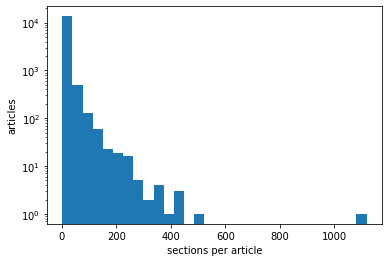

In [24]:
# How many sections per article?
plt = section_counts.plot(kind='hist', bins=30, logy=True)
plt.set_xlabel('sections per article')
plt.set_ylabel('articles')

<AxesSubplot:>

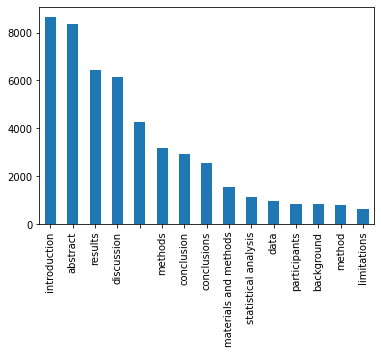

In [25]:
# quick look at section titles
articles['section_title'].str.lower().value_counts()[:15].plot(kind='bar')

In [28]:
# tokenization
def tokenize(text):
    '''prepare the text for cleaning by tokenizing strings into words'''
    try:
        sentence_list = nltk.sent_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        word_list = [tokenizer.tokenize(s) for s in sentence_list]
    except:
        word_list = text
    
    return word_list

In [31]:
articles['section_title_cleaned'] = articles['section_title'].apply(lambda x: str(x)) # make sure nulls are treated as str
articles['section_title_lower'] = articles['section_title_cleaned'].str.lower() # lowercase standardization
articles['section_title_cleaned'] = articles['section_title_lower'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x)) # remove all non-word characters
articles['section_title_tokenized'] = articles['section_title_cleaned'].progress_apply(word_tokenize) # tokenize

articles.loc[2,'section_title_tokenized'] # check output

['part',
 '3',
 'trials',
 'in',
 'colombia',
 'and',
 'the',
 'us',
 'for',
 'those',
 'at',
 'highest',
 'risk']

In [32]:
# remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

articles['section_title_tokenized_stop_rem'] = articles['section_title_tokenized'].progress_apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# lemmatize with POS tags applied
# use spaCy to do this in a more streamlined fashion than NLTK # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(l):
    '''use context-aware lemmatization from spacy on cleaned and stopword-removed tokens'''
    string = ' '.join(l) 
    doc = nlp(string)
    tokens = [token.lemma_ for token in doc]
    string = ' '.join(tokens)
    return string

articles['spacy'] = articles['section_title_tokenized_stop_rem'].progress_apply(lemmatize)

articles.head()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


,section_title,text,article_id,section_title_cleaned,section_title_lower,section_title_tokenized,section_title_tokenized_stop_rem,spacy
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77,,,[],[],
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77,part 2 can alzheimer's prevention initiative b...,part 2: can alzheimer's prevention initiative ...,"[part, 2, can, alzheimer, 's, prevention, init...","[part, 2, alzheimer, 's, prevention, initiativ...",part 2 alzheimer 's prevention initiative brea...
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77,part 3 trials in colombia and the us for those...,part 3: trials in colombia and the u.s. for th...,"[part, 3, trials, in, colombia, and, the, us, ...","[part, 3, trials, colombia, us, highest, risk]",part 3 trial colombia we high risk
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77,part 4 for shared prevention trials devil is i...,"part 4: for shared prevention trials, devil is...","[part, 4, for, shared, prevention, trials, dev...","[part, 4, shared, prevention, trials, devil, d...",part 4 share prevention trial devil detail
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77,drug selection can we have privacy please,"drug selection: can we have privacy, please!","[drug, selection, can, we, have, privacy, please]","[drug, selection, privacy, please]",drug selection privacy please


In [34]:
articles.to_pickle('./interim/articles_lemmatized.pkl')

In [52]:
# Find and visualize n-grams for common terms in section titles
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

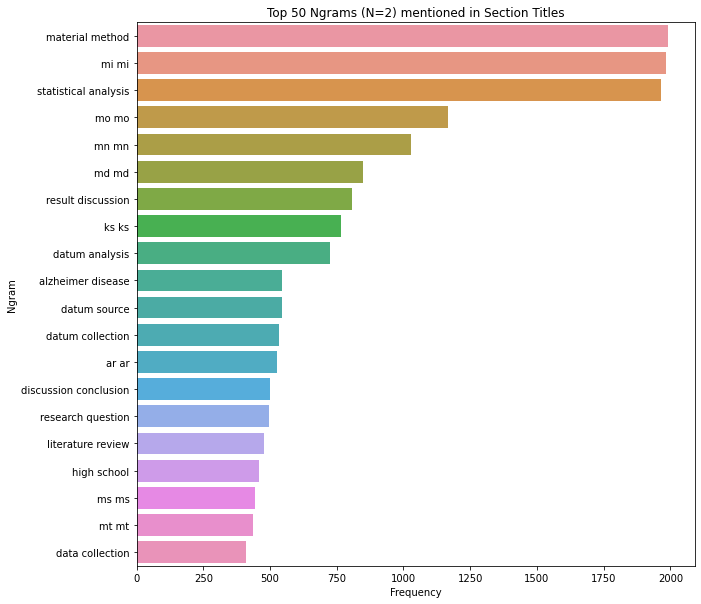

In [65]:
# From data_cleanup notebook, updated to accomodate both bigrams and trigrams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new=text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:50]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel(f"Frequency")
    plt.ylabel(f"Ngram")
    plt.title(f"Top 50 Ngrams (N={n}) mentioned in Section Titles")
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(articles['spacy'],2)

In [62]:
# Tables including state names seem to be skewing the bigrams
articles[articles['spacy'].str.contains('ar ar')]

,section_title,text,article_id,section_title_cleaned,section_title_lower,section_title_tokenized,section_title_tokenized_stop_rem,spacy
8083,Ventricular arrhythmias,"As with HF, the incidence of heart rhythm diso...",c397c293-bdea-4380-9698-8001f2c598e9,ventricular arrhythmias,ventricular arrhythmias,"[ventricular, arrhythmias]","[ventricular, arrhythmias]",ventricular arrhythmia
8085,Sustained ventricular arrhythmias,The main aetiology of sustained VT in aging pe...,c397c293-bdea-4380-9698-8001f2c598e9,sustained ventricular arrhythmias,sustained ventricular arrhythmias,"[sustained, ventricular, arrhythmias]","[sustained, ventricular, arrhythmias]",sustained ventricular arrhythmia
192702,Rutdiagram som visar styrkan i samvariationen ...,,7d4cda25-c17e-40e5-a37d-55f480d6e815,rutdiagram som visar styrkan i samvariationen ...,rutdiagram som visar styrkan i samvariationen ...,"[rutdiagram, som, visar, styrkan, i, samvariat...","[rutdiagram, som, visar, styrkan, samvariation...",rutdiagram som visar styrkan samvariationen me...
207036,Molecular architectonics.,Histochemical and immunohistochemical methods ...,f35ee21e-3780-490e-801c-4c283e1b181b,molecular architectonics,molecular architectonics.,"[molecular, architectonics]","[molecular, architectonics]",molecular architectonic
219679,AR AR AR AR AR AR AR AR AR AR AR AR AR AR AR A...,,c25c3c5d-d335-4596-8bda-47d789ac0564,ar ar ar ar ar ar ar ar ar ar ar ar ar ar ar a...,ar ar ar ar ar ar ar ar ar ar ar ar ar ar ar a...,"[ar, ar, ar, ar, ar, ar, ar, ar, ar, ar, ar, a...","[ar, ar, ar, ar, ar, ar, ar, ar, ar, ar, ar, a...",ar ar ar ar ar ar ar ar ar ar ar ar ar ar ar a...
239510,Coursetaking in Various Curricular Areas,First-generation students were less likely tha...,775a4e16-b3c5-44d4-9d1a-05235875f79f,coursetaking in various curricular areas,coursetaking in various curricular areas,"[coursetaking, in, various, curricular, areas]","[coursetaking, various, curricular, areas]",coursetake various curricular area
239515,Coursetaking Across Curricular Areas,Students whose parents were college educated a...,775a4e16-b3c5-44d4-9d1a-05235875f79f,coursetaking across curricular areas,coursetaking across curricular areas,"[coursetaking, across, curricular, areas]","[coursetaking, across, curricular, areas]",coursetake across curricular area


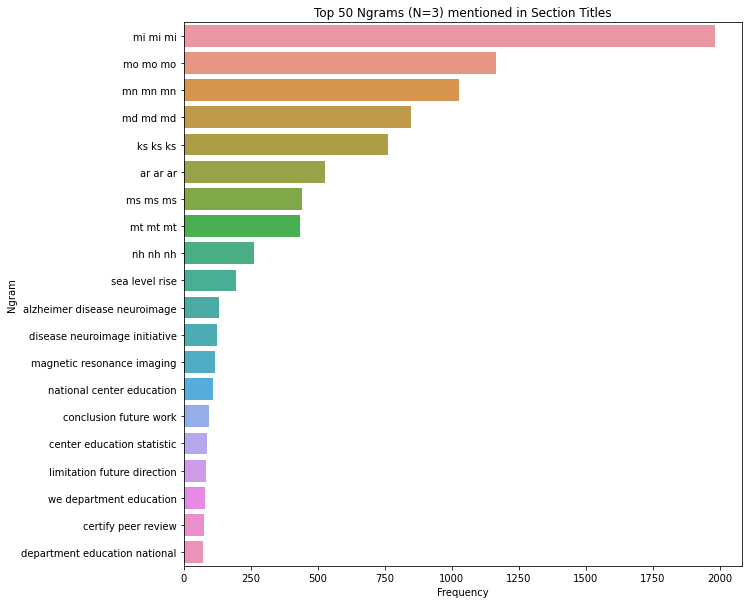

In [67]:
# Plot trigrams
plot_top_ngrams_barchart(articles['spacy'],3)

In [ ]:
# Drop section titles that have state abbreviations from tables
# How did other teams handle this aspect of dataset cleaning?

In [ ]:
# Standardize section names - flag if terms appear in top trigrams or bigrams, if so - which?
'''
If a section title includes a top 30 bigram or trigram, flag it in new column
Otherwise, pass / add nothing to the new series
'''

In [ ]:
# Implement POS tags for section titles

In [ ]:
# Find sections where dataset citations are most likely to occur using train dataset
